In [1]:
import os
from operator import index
import numpy as np
import pandas as pd
from sqlalchemy import create_engine

import mipipe as mip

# MySQL 데이터베이스 연결 정보
username = 'root'
password = os.getenv('AIMED_PW')
host = '172.28.8.103'
port = '3306'  # 예: '3306'
database = "MIMIC_III"
db_engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

In [ ]:
from importlib import reload

reload(mip)  # mymodule을 다시 로드하여 변경 사항 반영.

In [ ]:
query = "SELECT * FROM CHARTEVENTS LIMIT 10000;"
icu_patient = pd.read_sql(query, db_engine)
icu_patient

In [12]:
# read json file
import json

with open('X.feature_names.json') as f:
    x_feature_names = json.load(f)

d_items = pd.read_csv("../mimic3_csv/D_ITEMS.csv")  # D_ITEMS.csv
d_labitems = pd.read_csv("../mimic3_csv/D_LABITEMS.csv")  # D_LABITEMS.csv
x_feature_names

chartitem_map = {}
labitem_map = {}

for item_id in x_feature_names:
    id = item_id.split("_")[0]
    # if id is number
    if id.isdigit():
        id = int(id)
        try:
            label = d_items[d_items["ITEMID"] == id]
            chartitem_map[id] = label["LABEL"].values[0]
        except:
            try:
                label = d_labitems[d_labitems["ITEMID"] == id]
                labitem_map[id] = label["LABEL"].values[0]
            except:
                print("NOT FOUND: ", id)

In [ ]:
import pandas as pd
import multiprocessing as mp


def process_group(group):
    # 그룹 데이터 처리 함수
    return group.mean()  # 예시로 그룹의 평균값을 계산


def parallel_process_dataframe(df):
    with mp.Pool(mp.cpu_count()) as pool:
        result = pool.map(process_group, [group for name, group in df.groupby('ID')])
    return pd.concat(result)


# 예시 데이터프레임
df = pd.DataFrame({
    'ID': [1, 1, 2, 2, 3, 3],
    'value': [10, 20, 30, 40, 50, 60]
})

result_df = parallel_process_dataframe(df)
print(result_df)

In [4]:
query = "SELECT * FROM CHARTEVENTS WHERE ITEMID IN (220210, 224690, 224167, 227243, 220050, 220179, 225309, 224639, 226512, 226531) ORDER BY CHARTTIME LIMIT 100000;"
icu_patient_original = pd.read_sql(query, db_engine)
icu_patient_original = mip.chartevents_group_variables(icu_patient_original)

In [18]:
icu_patient = icu_patient_original[icu_patient_original["ICUSTAY_ID"].isin([200290, 299853])]
icu_agg = mip.chartevents_aggregator(icu_patient, [220179, 220210, 224639], ["mean", "min"])
icu_agg

ICUSTAY_ID   T      220179            220210           224639           
                         mean    min       mean   min       mean        min
0      200290   0         NaN    NaN        NaN   NaN  95.272641  95.208961
1      200290   1  121.833333  107.0  15.857143  14.0        NaN        NaN
2      200290   2  119.333333  102.0  16.000000  16.0        NaN        NaN
3      200290   3  127.500000  119.0  16.000000  16.0        NaN        NaN
4      200290   4  124.333333  106.0  17.666667  16.0        NaN        NaN
..        ...  ..         ...    ...        ...   ...        ...        ...
82     299853  51  101.000000  101.0  11.000000  11.0        NaN        NaN
83     299853  52  113.000000  113.0   2.000000   2.0        NaN        NaN
84     299853  53  104.000000  104.0  14.000000  14.0        NaN        NaN
85     299853  54  111.000000  110.0  19.000000  19.0        NaN        NaN
86     299853  55  109.000000  109.0  17.000000  17.0        NaN        NaN

[87 rows x 8 columns]

In [24]:
chart_itemid = list(chartitem_map.keys())
chart_itemid

[220048,
 220046,
 220047,
 220052,
 220056,
 220058,
 220059,
 220060,
 220061,
 220063,
 220066,
 220072,
 220073,
 220074,
 220088,
 220120,
 220181,
 220194,
 220292,
 220293,
 220339,
 220739,
 220765,
 220862,
 220864,
 220949,
 220950,
 220952,
 220970,
 220995,
 221036,
 221214,
 221216,
 221217,
 221223,
 221255,
 221282,
 221289,
 221319,
 221347,
 221385,
 221393,
 221429,
 221456,
 221468,
 221555,
 221623,
 221653,
 221662,
 221668,
 221712,
 221744,
 221749,
 221794,
 221824,
 221828,
 221833,
 221906,
 221986,
 222011,
 222021,
 222042,
 222051,
 222056,
 222062,
 222168,
 222315,
 222318,
 223253,
 223257,
 223258,
 223259,
 223260,
 223261,
 223262,
 223751,
 223752,
 223753,
 223754,
 223758,
 223759,
 223760,
 223763,
 223765,
 223766,
 223767,
 223768,
 223769,
 223770,
 223771,
 223772,
 223773,
 223780,
 223781,
 223782,
 223783,
 223784,
 223791,
 223792,
 223794,
 223795,
 223796,
 223797,
 223800,
 223801,
 223802,
 223805,
 223806,
 223810,
 223811,
 223814,
 

In [6]:
query = "SELECT * FROM CHARTEVENTS ORDER BY CHARTTIME LIMIT 100000;"
icu_patient_original_2 = pd.read_sql(query, db_engine)
describe = mip.chart_item_interval_describe(icu_patient_original_2)

C:\Users\airro\anaconda3\envs\sandbox_py3_10_14\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


클러스터 중심점:
      count      mean       std       min       25%       50%       75%  \
0  0.161071 -0.447506 -0.456483 -0.217049 -0.290511 -0.325912 -0.406762   
1 -0.550185  2.995175  0.933679  1.831420  3.084353  3.362841  3.189222   
2 -0.417463  0.703041  1.377965  0.223032  0.101331  0.144005  0.493649   

        max  
0 -0.391521  
1  0.203274  
2  1.367982  

데이터에 클러스터 라벨 추가:
        count       mean        std       min       25%       50%        75%  \
ITEMID                                                                         
226381   45.0  17.962222  33.368763  0.016667  0.350000  6.533333  25.200000   
226543   48.0  17.569097  32.445798  0.016667  0.412500  6.633333  25.450000   
226544   48.0  17.569097  32.445798  0.016667  0.412500  6.633333  25.450000   
227378   34.0   8.446569  12.472510  0.016667  0.104167  2.741667   9.604167   
227688   36.0   5.600926  25.583001  0.016667  0.062500  0.383333   1.808333   

               max  Cluster  
ITEMID                  

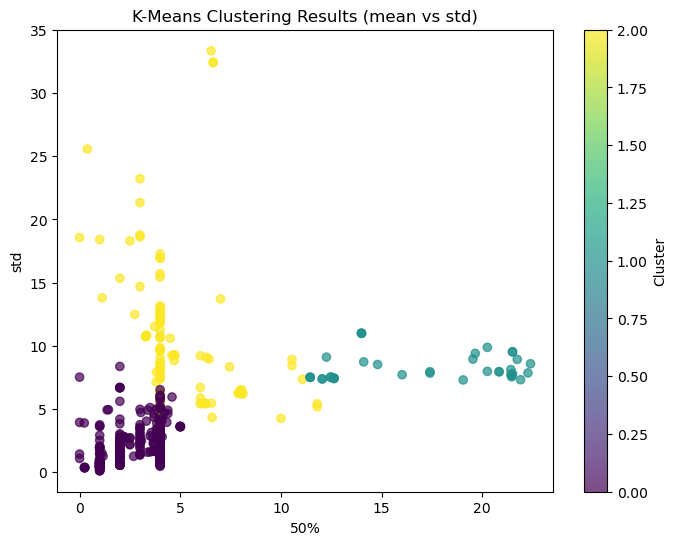

In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 데이터프레임 예시 (위 데이터프레임 사용 가정)
# 데이터 로딩: 사용자 데이터프레임 준비
data = k_data = describe[describe["count"] >= 30].copy()  # 입력된 데이터프레임

# STEP 1: 수치형 데이터만 선택
numeric_cols = ["count", "mean", "std", "min", "25%", "50%", "75%", "max"]
X = data[numeric_cols]

# STEP 2: 데이터 정규화 (Standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# STEP 3: K-Means 클러스터링 수행
n_clusters = 3  # 클러스터 개수 설정
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data["Cluster"] = kmeans.fit_predict(X_scaled)

# STEP 4: 클러스터링 결과 확인
print("클러스터 중심점:")
print(pd.DataFrame(kmeans.cluster_centers_, columns=numeric_cols))

print("\n데이터에 클러스터 라벨 추가:")
print(data.head())

# STEP 5: 시각화
x_axis = "50%"
y_axis = "std"
plt.figure(figsize=(8, 6))
plt.scatter(data[x_axis], data[y_axis], c=data["Cluster"], cmap="viridis", alpha=0.7)
plt.title("K-Means Clustering Results (mean vs std)")
plt.xlabel(x_axis)
plt.ylabel(y_axis)
plt.colorbar(label="Cluster")
plt.show()

In [25]:
item_c = {0: list(data[data["Cluster"] == 0].index),
            1: list(data[data["Cluster"] == 1].index),
            2: list(data[data["Cluster"] == 2].index)}
item_t = {0: 1, 1: 12, 2: 4}

In [47]:
def _chartevents_aggregate_post_processing(icu_agg: pd.DataFrame, item_c,  item_t, statistics: list[str] = None) -> pd.DataFrame:

    if statistics is None:
        statistics = ["mean"]

    # icustay_id = icu_agg["ICUSTAY_ID"].unique()
    # assert len(icustay_id) == 1, "Multiple icustay_id in the dataframe. Only one icustay_id is allowed."
    # icustay_id = icu_agg["ICUSTAY_ID"].iloc[0]

    for key, item_cluster in item_c.items():
        columns = ["T"] + item_cluster
        item_cluster_filter = set() -
        icu_filtered = icu_agg[item_cluster].copy()

        gap = item_t[key]

        icu_filtered["T_grp"] = (icu_filtered["T"] // gap) * gap

        agg_df = (icu_filtered
                  .groupby(["ICUSTAY_ID", "T_grp", "ITEMID"])
                  .agg(statistics)
                  .reset_index())

    return agg_df


icu_agg = _chartevents_aggregate_post_processing(icu_agg, item_c, item_t, ["mean", "std"])

KeyError: '[224168 224641 228305 220045 224642 220277 223761 223781 223782 223783\n 223791 223792 223795 220180 220181 226732 228096 228298 228299 223794\n 223796 225103 224015 220739 223900 223901 228394 228395 228396 228397\n 228398 228409 228410 228411 228412 228414 224073 227944 227969 224080\n 224082 224084 224086 224093 228306 223934 223943 223985 223986 223987\n 223988 223989 223990 223999 224003 224004 224026 224027 224028 224031\n 224054 224055 224056 224057 224058 224059 224860 220048 224650 224001\n 224016 224876 27 31 32 39 40 50 54 80 127 128 154 159 161 171 184 190 198\n 210 211 212 218 219 324 326 417 425 428 432 434 444 450 454 456 478 547\n 548 550 593 599 605 610 615 617 618 621 622 623 631 637 644 646 663 674\n 677 678 680 704 707 720 722 723 742 1046 1047 1125 1337 1425 1622 1623\n 6208 7915 479 506 156 157 294 300 455 549 706 1427 5815 5817 5819 5820\n 8402 8441 8456 8480 8549 8551 8553 8554 8381 8382 8400 581 8476 8477 656\n 657 1703 1087 525 527 202 477 8388 8492 200 203 1698 49 834 578 684 8367\n 5813 5814 52 51 584 585 620 596 648 655 130 197 423 426 465 470 590 8466\n 8467 8474 467 8368 229 232 283 1484 8392 576 676 113 411 386 392 398 8416\n 493 494 496 498 499 500 497 8449 8548 176 179 180 236 238 284 8393 235\n 8547 139 410 374 645 3446 3723 5909 5911 3338 3339 3348 3353 3373 3386\n 3519 3568 3580 3581 3582 3603 3607 3669 594 3340 3632 3291 3293 3686\n 223753 223780 223834 223754 223898 223902 223903 223910 223911 223916\n 224756 226104 226105 224017 227668 224085 224087 224089 225054 225185\n 225187 226137 227367 225234 223904 223905 226168 223907 223917 223918\n 223919 223920 223921 223923 227288 227375 227684 224759 227121 223924\n 224733 224758 3304 3450 3577 3609 3656 8499 8518 8529 8532 8537 3292 3335\n 3408 3476 3487 3559 3572 3627 3634 3655 3664 3694 5907 5912 3626 3652\n 3583 3692 3295 3642 3465 320 224000 224879 228099 224007 224785 225231\n 228013 228014 226138 227368 228100 224005 224040 224041 224043 224848\n 224851 227472 224088 224259 224847 227780 224564 224372 224373 3419 3570\n 3427 3428 3429 3430 3523 216 3547 224188 227759 226115 227358 224226\n 224042 5908 220074 220050 220051 223835 220292 220293 220339 223873\n 223874 223875 223876 224685 224686 224689 224690 224695 224697 223837\n 223838 223848 223849 224415 224832 227369 228101 226139 224119 224687\n 220052 227960 227961 227945 227946 227947 227948 227949 227950 227951\n 227952 227953 227954 227955 227956 227957 227958 227959 224701 228404\n 228405 228406 228407 227517 227664 226169 8521 8448 679 1704 492] not in index'

In [45]:
item = [220179, 220210]
icu_agg[item]

220179            220210      
          mean    min       mean   min
0          NaN    NaN        NaN   NaN
1   121.833333  107.0  15.857143  14.0
2   119.333333  102.0  16.000000  16.0
3   127.500000  119.0  16.000000  16.0
4   124.333333  106.0  17.666667  16.0
..         ...    ...        ...   ...
82  101.000000  101.0  11.000000  11.0
83  113.000000  113.0   2.000000   2.0
84  104.000000  104.0  14.000000  14.0
85  111.000000  110.0  19.000000  19.0
86  109.000000  109.0  17.000000  17.0

[87 rows x 4 columns]